In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, expon, beta
%matplotlib inline
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

sns.set(font_scale=2)

In [ ]:
N = 100
x = np.random.normal(size=N)

In [ ]:
sigma_hat = np.sqrt(((x - x.mean())**2).mean())

In [ ]:
B = 10000
x_boot = x[np.random.choice(N, size=(N, B), replace=True)]

In [ ]:
plt.hist(np.sqrt(((x_boot - x_boot.mean(axis=0))**2).mean(axis=0)))
plt.axvline(sigma_hat, c='r')

In [ ]:
sigma_boot = np.sqrt(((x_boot - x_boot.mean(axis=0))**2).mean(axis=0))

In [ ]:
(sigma_boot - sigma_hat).mean()

In [ ]:
sigma_hat - np.std(x, ddof=1)

# 1. Analysis of Deviance

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [ ]:
gf = pd.read_csv('../05_glm/data/gforces.txt', sep='\t')
# make all columns lower case:
gf.columns = [c.lower() for c in gf.columns]
gf = gf.sort_values("age")
print(gf)

In [ ]:
fit_const = smf.glm('signs ~ 1', 
                    data=gf, 
                    family=sm.families.Binomial()).fit()
fit = smf.glm('signs ~ age', 
              data=gf, 
              family=sm.families.Binomial()).fit()
print(fit.summary())

In [ ]:
gf.age.min(), gf.age.max()

In [ ]:
X = np.linspace(gf.age.min() - 10, gf.age.max() + 10, 100)
y_const = fit_const.predict(pd.DataFrame(X.reshape(-1, 1), columns=["age"]))
y = fit.predict(pd.DataFrame(X.reshape(-1, 1), columns=["age"]))

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(X, y, label="Fitter logistic model")
plt.plot(X, y_const, label="The null model")
plt.plot(gf["age"], gf["signs"], label="Saturated model")
plt.legend()
plt.show()

## Deviance

Девианс это обобщение суммы квадратов разниц для обобщённых линейных моделей:

\begin{align*}
D:=-2\left[\ell(\hat{\boldsymbol{\beta}})-\ell_s\right]\phi.
\end{align*}

Нулевой девианс это девианс посчитанный когда модель включает только предсказание среднего:

\begin{align*}
D_0:=-2\left[\ell(\hat{\beta}_0)-\ell_s\right]\phi,
\end{align*}

В случае экспоненциального семейства девианс можно расписать следующим образом:

\begin{align}
D&=-\frac{2}{a(\phi)}\sum_{i=1}^n\left(Y_i\hat\theta_i-b(\hat\theta_i)-Y_ig(Y_i)+b(g(Y_i))\right)\phi\nonumber\\
&=\frac{2\phi}{a(\phi)}\sum_{i=1}^n\left(Y_i(Y_i-\hat\theta_i)-b(g(Y_i))+b(\hat\theta_i)\right)
\end{align}




![img](https://bookdown.org/egarpor/PM-UC3M/images/figures/deviance.png)


## Пара экспериментов с игрушечной задачей

In [ ]:
def logit(x): 
    return(1. / (1. + np.exp(-x)))

def generate_problem(N=100, beta_1=1.5, beta_2=-1.): 
    x_1 = np.random.randn(N)
    x_2 = np.random.randn(N)
    x_3 = np.random.randn(N)
    noise = np.random.randn(N)

    y = x_1 * beta_1 + x_2 * beta_2 + noise
    return np.vstack([x_1, x_2, x_3]).T, np.round(logit(y))

In [ ]:
from tqdm import tqdm

deviance_predictor_1 = []
deviance_predictor_2 = []
null_deviance = []

for _ in tqdm(range(1000)):
    try:
        X, y = generate_problem(N=1000)
        data = pd.DataFrame(np.hstack([X, y.reshape(-1, 1)]), columns=["x1", "x2", "x3", "y"])
        fit1 = smf.glm('y ~ x1 + x3', 
                       data=data, 
                       family=sm.families.Binomial()).fit()
        fit2 = smf.glm('y ~ x1 + x2 + x3', 
                       data=data, 
                       family=sm.families.Binomial()).fit()
    except:
        continue
    deviance_predictor_1.append(fit1.deviance)
    deviance_predictor_2.append(fit2.deviance)
    null_deviance.append(fit1.null_deviance)
    
deviance_predictor_1 = np.array(deviance_predictor_1)
deviance_predictor_2 = np.array(deviance_predictor_2)
null_deviance = np.array(null_deviance)

Q: какое распределение будет у девианса?

In [ ]:
plt.hist(deviance_predictor_1, bins=100);
plt.hist(deviance_predictor_2, bins=100);

In [ ]:
f_hat = (
    (deviance_predictor_1 - deviance_predictor_2) / (fit2.df_model - fit1.df_model) / 
    (deviance_predictor_2 / (len(X) - fit2.df_model - 1))
)

Q: какое распределение у f_hat?

In [ ]:
from scipy.stats import f
dfn, dfd = len(X) - 2 - 1, 1 # <>

x = np.linspace(f.ppf(0.01, dfn, dfd),
                f.ppf(0.80, dfn, dfd), 100)

plt.figure(figsize=(12, 8))

plt.hist(
    f_hat, 
    density=True,
    bins=40);
plt.plot(x, f.pdf(x, dfn, dfd), 'r-', lw=5, alpha=0.6, label='f pdf')
plt.title('F-distribution')

plt.xlabel('x')
plt.ylabel('pdf')

plt.show()

## Analysis of Deviance это обобщение Analysis of Variance для GLM

\begin{align*}
H_0:\beta_{p_1+1}=\ldots=\beta_{p_2}=0\quad\text{vs.}\quad H_1:\beta_j\neq 0\text{ for any }p_1<j\leq p_2.
\end{align*}


\begin{align*}
F=\frac{(D^*_{p_1}-D^*_{p_2})/(p_2-p_1)}{D^*_{p_2}/(n-p_2-1)}=\frac{(D_{p_1}-D_{p_2})/(p_2-p_1)}{D_{p_2}/(n-p_2-1)}\stackrel{a,\,H_0}{\sim} F_{p_2-p_1,n-p_2-1}.
\end{align*}

# 2. ROC-AUC

## 2.1 Критерий Манна-Уитни


##### Критерий Манна-Уитни (рабоче-крестьянский алгоритм)

Критерий Манна-Уитни используется для сравнения средних двух групп.

Cтатистика U считается следующим образом для двух выборок X и Y: 
  0. $U_1 = 0$
  1. Берутся все пары из двух выборок: $(x_i, y_i)$;
  2. Если $x_i > y_i$, то $U_1 += 1$;
  3. Если $x_i == y_i$, то $U_1 += 0.5$;
  4. Аналогично считается $U_2$ по парам $(y_i, x_i)$;
  5. $U = min(U_1, U_2)$
 
При больших размерах выборки:

$$U \sim N\left(\frac{mn}{2}, \frac{mn(n + m + 1)}{12}\right)$$

При большой выборке и __возможных ничьих__ $\sigma$ считается по-другому:

$$
\sigma = \sqrt{ \frac{nm}{(m + n) (m + n - 1)} \cdot \left[ \frac{(m + n)^3 - (m + n)}{12} - \sum \frac{t_j^3 - t_j}{12} \right]},
$$

где $t_j$ -- количество ничьих.


#### Замечательность рангового теста Манна-Уитни: 

  * работает для всех типов данных данных;
  * не обращает внимание на outliers;
  * связан с ROC-AUC.
  
  
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1120984/

## 2.2 ROC-AUC

ROC-AUC и статистика Манна-Уитни связаны очень простым соотношением:

$$\mathrm{ROC-AUC} = \frac{U}{n m }$$

$U$ считается по вероятностям, которые выдал классификатор, а $n$ и $m$ — количество положительных и отрицательных примеров в датасете.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from scipy.stats import rankdata, tiecorrect, mannwhitneyu


X, y = make_classification(n_samples=200, n_features=10, n_redundant=8, class_sep=0.9, 
                           n_informative=2, random_state=1337)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1337)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lr = LogisticRegression().fit(X_train, y_train)

y_pred = lr.predict_proba(X_test)[:, 1]

print('ROC-AUC={}'.format(roc_auc_score(y_test, y_pred)))

ROC-AUC=0.9056000000000001


In [7]:
y_test_colors = y_test.copy().astype(np.object)
y_test_colors[y_test==0] = ['r']
y_test_colors[y_test==1] = ['g']

y_pred_argsorted = np.argsort(y_pred)


y_pred = y_pred[y_pred_argsorted]
y_test_colors = y_test_colors[y_pred_argsorted]
y_test = y_test[y_pred_argsorted]
X_test = X_test[y_pred_argsorted]

<ipython-input-7-286e9efae607>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_test_colors = y_test.copy().astype(np.object)


Посчитаем Манна-Уитни с помощью функции из `scipy.stats`.

In [ ]:
mannwhitneyu?

In [8]:
mannwhitneyu(y_pred[y_test==1], y_pred[y_test==0], 
             alternative='two-sided')

MannwhitneyuResult(statistic=566.0, pvalue=9.157883328039219e-07)

In [10]:
n = np.sum(y_test==1)  # количество объектов положительного класса
m = np.sum(y_test==0)  # количесво объектов отрицательного класса

In [11]:
n, m

(25, 25)

Удостоверимся в равенстве:

$$\mathrm{ROC-AUC} = \frac{U}{n m }$$

In [12]:
mannwhitneyu(y_pred[y_test==1], y_pred[y_test==0], 
             alternative='two-sided')[0] / (n * m)

0.9056

Отлично!

Теперь для интерпретации ROC-AUC нам потребуется вытащить ранги. 

Ранг это порядок в отсортированном массиве.

In [13]:
ranks = rankdata(y_pred)
pos_ranks = ranks[y_test == 1]

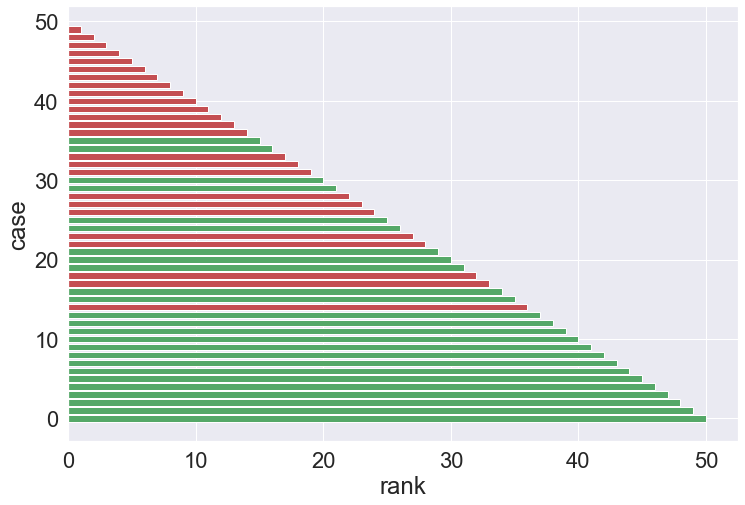

In [14]:
plt.figure(figsize=(12, 8))

plt.barh(np.arange(len(y_pred))[::-1], ranks, color=y_test_colors)

plt.ylabel('case')
plt.xlabel('rank')
plt.show()

In [15]:
x_offset = m + np.arange(1, n + 1) - pos_ranks

In [16]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

roc_auc = roc_auc_score(y_test, y_pred)

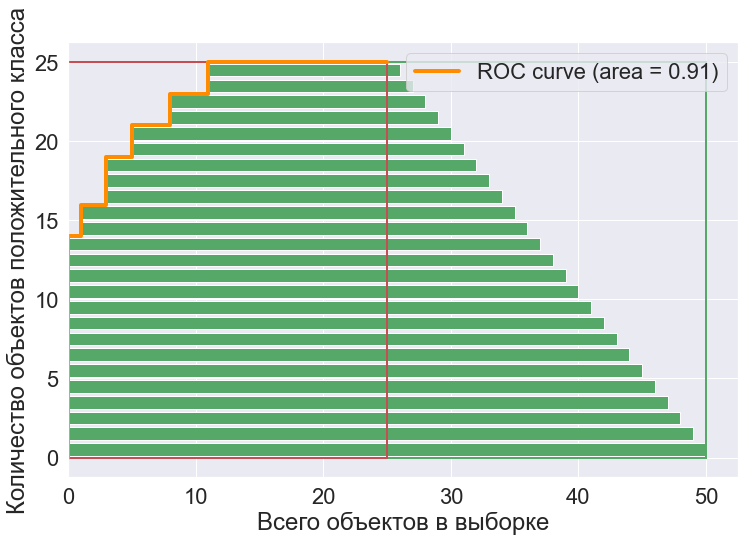

In [17]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(12, 8))
plt.barh(y=np.arange(n)[::-1] + 0.5, width=pos_ranks, left=x_offset, color='g')
plt.plot(m * fpr, n * tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc, lw=4)
plt.gca().add_patch(plt.Rectangle(xy=(m, 0), edgecolor='g',
                                  height=n, width=n, fill=False, linewidth=2))
plt.gca().add_patch(plt.Rectangle(xy=(0, 0), edgecolor='r',
                                  height=n, width=m, fill=False, linewidth=2))
plt.xlabel('Всего объектов в выборке')
plt.ylabel('Количество объектов положительного класса')
plt.legend(loc='best')
plt.show()

## Применим это к реальной задаче

Прочитаем данные и разобъём их на train/test выборки.

In [44]:
X = pd.read_csv('./cell2celltrain.csv')
msk = np.random.rand(len(X)) < 0.8
X_train = X[msk].copy()
X_test = X[~msk].copy()

columns = ['MonthlyRevenue', 'MonthlyMinutes',
           'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes',
           'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues',
           'DroppedCalls', 'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls',
           'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls',
           'PeakCallsInOut', 'OffPeakCallsInOut', 'DroppedBlockedCalls',
           'CallForwardingCalls', 'CallWaitingCalls', 'MonthsInService',
           'UniqueSubs', 'ActiveSubs', 'Handsets', 'HandsetModels',
           'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2', 'ChildrenInHH',
           'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'RVOwner',
           'BuysViaMailOrder', 'RespondsToMailOffers',
           'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard',
           'RetentionCalls', 'RetentionOffersAccepted', 'NewCellphoneUser',
           'NotNewCellphoneUser', 'ReferralsMadeBySubscriber', 'IncomeGroup',
           'OwnsMotorcycle', 'AdjustmentsToCreditRating', 'HandsetPrice',
           'MadeCallToRetentionTeam', 'CreditRating', 'Occupation',
           'MaritalStatus']

Выкинем колонки `'ServiceArea', 'Homeownership', 'PrizmCode'`.

In [45]:
drop_columns = ['ServiceArea', 'Homeownership', 'PrizmCode']

X_train.drop(labels=drop_columns, axis=1, inplace=True)
X_test.drop(labels=drop_columns, axis=1, inplace=True)

Бинарные колонки закодируем как `0/1`.

In [46]:
bin_cols = ['Churn', 'HandsetRefurbished', 'HandsetWebCapable', 'RespondsToMailOffers',
            'TruckOwner', 'RVOwner', 'BuysViaMailOrder', 'OptOutMailings', 'NonUSTravel',
            'OwnsComputer', 'HasCreditCard', 'NewCellphoneUser', 'NotNewCellphoneUser',
            'OwnsMotorcycle', 'MadeCallToRetentionTeam', 'ChildrenInHH', 'MaritalStatus']
def preprocess_bin_cols(X, cols):
    for col in cols:
        X[col] = X[col].apply(lambda x: 1 if x == 'Yes' else 0)
        
        
preprocess_bin_cols(X_train, bin_cols)
preprocess_bin_cols(X_test, bin_cols)

In [47]:
def ohe(X_train, X_test, col):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    le.fit(X_train[col])
    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

ohe(X_train, X_test, 'CreditRating')
ohe(X_train, X_test, 'Occupation')

Избавимся от NaN-данных.

In [48]:
X_train[X_train == 'Unknown'] = np.nan
X_train.fillna(0, inplace=True)

X_test[X_test == 'Unknown'] = np.nan
X_test.fillna(0, inplace=True)

Переводим в numpy-формат.

In [49]:
y_train = X_train.Churn.values
X_train = X_train[columns].values.astype(float)

y_test = X_test.Churn.values
X_test = X_test[columns].values.astype(float)

In [27]:
lr = LogisticRegression().fit(X_train, y_train)

y_pred = lr.predict_proba(X_test)[:, 1]

print('ROC-AUC={}'.format(roc_auc_score(y_test, y_pred)))

ROC-AUC=0.5841444108096284


In [28]:
y_test_colors = y_test.copy().astype(np.object)
y_test_colors[y_test==0] = ['r']
y_test_colors[y_test==1] = ['g']

y_pred_argsorted = np.argsort(y_pred)

y_pred = y_pred[y_pred_argsorted]
y_test_colors = y_test_colors[y_pred_argsorted]
y_test = y_test[y_pred_argsorted]
X_test = X_test[y_pred_argsorted]

<ipython-input-28-7d427e77a8fe>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_test_colors = y_test.copy().astype(np.object)


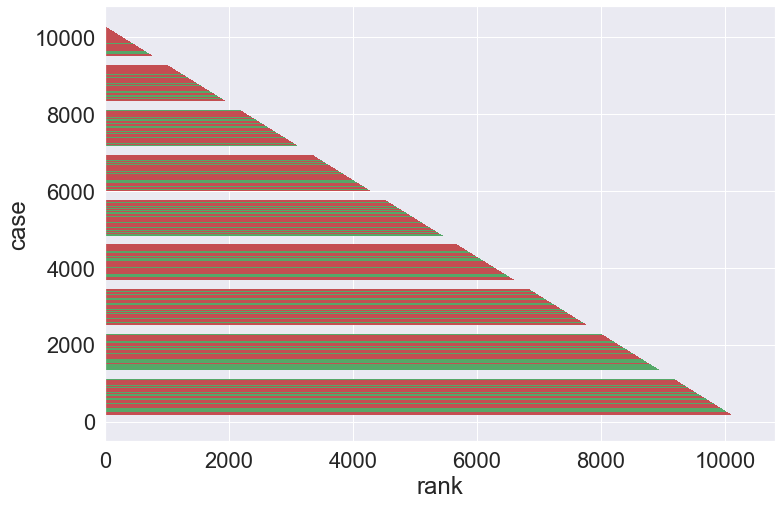

In [29]:
ranks = rankdata(y_pred)
pos_ranks = ranks[y_test == 1]

plt.figure(figsize=(12, 8))

plt.barh(np.arange(len(y_pred))[::-1], ranks, color=y_test_colors, edgecolor='none')

plt.ylabel('case')
plt.xlabel('rank')
plt.show()

In [30]:
n = np.sum(y_test==1)  # количество объектов положительного класса
m = np.sum(y_test==0)  # количесво объектов отрицательного класса

x_offset = m + np.arange(1, n + 1) - pos_ranks

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

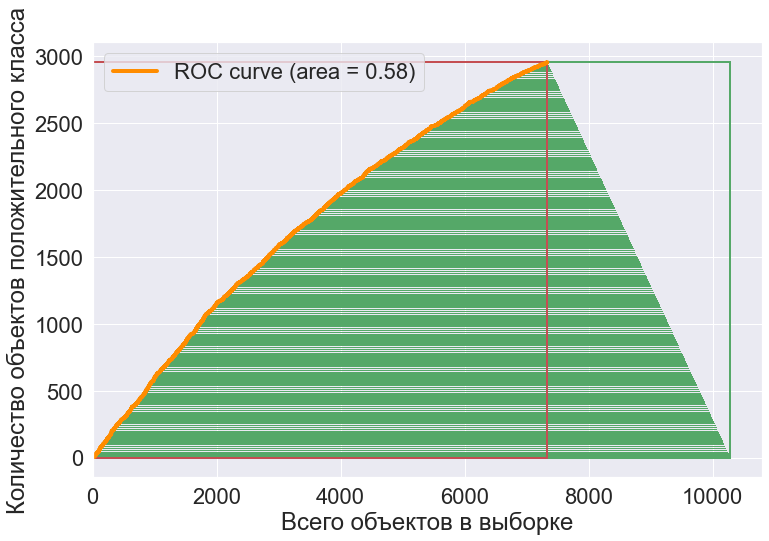

In [32]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(12, 8))
plt.barh(y=np.arange(n)[::-1] + 0.5, width=pos_ranks, left=x_offset, color='g', edgecolor='none')
plt.plot(m * fpr, n * tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc, lw=4)
plt.gca().add_patch(plt.Rectangle(xy=(m, 0), edgecolor='g',
                                  height=n, width=n, fill=False, linewidth=2))
plt.gca().add_patch(plt.Rectangle(xy=(0, 0), edgecolor='r',
                                  height=n, width=m, fill=False, linewidth=2))
plt.xlabel('Всего объектов в выборке')
plt.ylabel('Количество объектов положительного класса')
plt.legend(loc='best')
plt.show()

## 2.3 Три способа посчитать дисперсию ROC-AUC

### 2.3.1 Из предельного распределения статистики Манна-Уитни

При больших размерах выборки, как было написано выше:

$$U \sim \mathcal{N}\left(\frac{mn}{2}, \frac{mn(n + m + 1)}{12}\right)$$

то для ROC-AUC предельное распределение будет следующим:

$$ \mathrm{ROC-AUC} \sim \mathcal{N} \left(\frac{1}{2}, \frac{n + m + 1}{12 n m}\right) $$

В данном контексте $n$ и $m$ количество положительных и отрицательных примеров в выборке.

В данном вражении нас интересует только оценка стандартного отклонения:

$$\hat{se} = \sqrt{\frac{n + m + 1}{12 n m}}$$

Замечательностью и слабостью данной формулы является её независимость от $\widehat{AUC}$, т.е. можно использовать для планирования эксперимента при известных априорных распределений на $n$ и $m$.

In [33]:
def roc_auc_variance_from_mann_whitney(n1, n2):
    return (n1 + n2 + 1) / (12 * n1 * n2)

### 2.3.2 Метод ``Mcneil''

https://pubs.rsna.org/doi/10.1148/radiology.143.1.7063747

http://cejsh.icm.edu.pl/cejsh/element/bwmeta1.element.desklight-1f1afc51-6102-491f-a21d-de29ae98ce3b/c/MIBE_T15_z2_36.pdf

![](var_auc.png)

В данном контексте $\theta$ -- "истинный" ROC-AUC.

$$\hat{se} = \sqrt{ \frac{ (\hat{AUC} (1 - \hat{AUC}) + (n - 1)(Q_1 - \hat{AUC}^2) + (m - 1)(Q_2 - \hat{AUC}^2) )() }{n m} }$$

Плюс:
  * учитывает полученное значение AUC.

Минус:
  * сильное предположение о нормальности распределения.

In [34]:
def roc_auc_variance(auc, n1, n2):
    q1 = auc / (2 - auc)
    q2 = 2 * auc**2 / (1 + auc)
    return (auc * (1 - auc) + (n1 - 1) * (q1 - auc**2) + (n2 - 1) * (q2 - auc**2)) / (n1 * n2)

### 2.3.3 Метод ДеЛонга 

https://www.ncbi.nlm.nih.gov/pubmed/3203132

Этот метод ещё дополнительно учитывает корреляции между положительным и отрицательными классами.

In [50]:
from compare_auc_delong_xu import delong_roc_variance

In [51]:
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

models = {
    'LogisticRegression': LogisticRegression(),
    'GaussianNB': GaussianNB(),
    'KNeighborsClassifier': KNeighborsClassifier()
}

In [52]:
from tqdm import tqdm
auc_var_naives = []
auc_var_params = []
auc_var_delongs = []
aucs = []
model_names = []

for model_name, model in tqdm(models.items()):
    # train model
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    # estimate auc and variance
    auc = roc_auc_score(y_test, y_pred)
    n, m = y_test.sum(), len(y_test) - y_test.sum()
    auc_var_naive = roc_auc_variance_from_mann_whitney(n, m)
    auc_var_param = roc_auc_variance(auc, n, m)
    _, auc_var_delong = delong_roc_variance(y_test, y_pred)
    
    # add stats to lists
    model_names.append(model_name)
    auc_var_naives.append(auc_var_naive)
    auc_var_params.append(auc_var_param)
    auc_var_delongs.append(auc_var_delong)
    aucs.append(auc)
    
auc_var_naives = np.sqrt(np.array(auc_var_naives))
auc_var_params = np.sqrt(np.array(auc_var_params))
auc_var_delongs = np.sqrt(np.array(auc_var_delongs))
aucs = np.array(aucs)

100%|██████████| 3/3 [00:06<00:00,  2.27s/it]


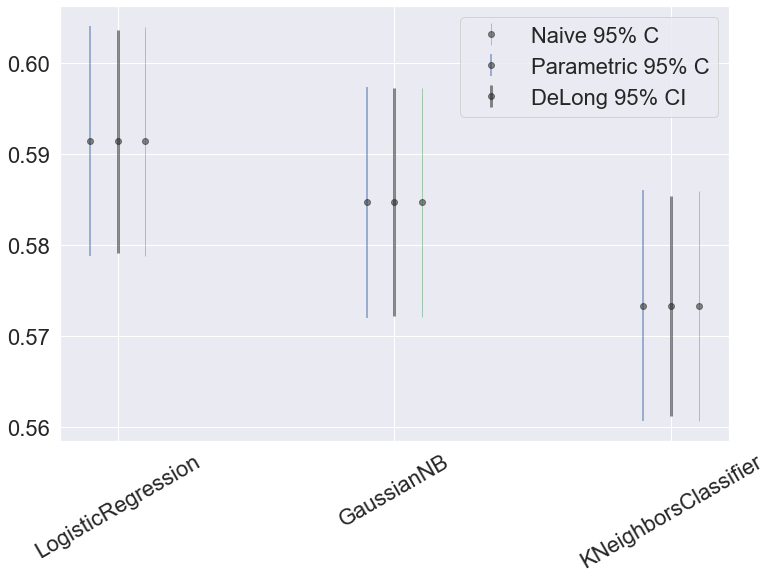

In [53]:
x = np.arange(len(aucs))
plt.figure(figsize=(12, 8))

plt.errorbar(x + 0.1, aucs, 2 * auc_var_naives, fmt='ok', lw=1, alpha=0.5, 
             ecolor='g', label='Naive 95% C')
plt.errorbar(x - 0.1, aucs, 2 * auc_var_params, fmt='ok', lw=2, alpha=0.5, 
             ecolor='b', label='Parametric 95% C')
plt.errorbar(x, aucs, 2 * auc_var_delongs, fmt='ok', lw=3, alpha=0.5, 
             ecolor='k', label='DeLong 95% CI')

plt.xticks(x, model_names, rotation=30)
plt.legend()
plt.show()

### Посмотрим на поведение стандартного отклонения ROC-AUC при маленькой выборке на искуственной задаче

Первая выборка сэмплируется из:

$$x_1 \sim \mathcal{N}(x_1 ; 0, 1)$$

Вторая выборка сэмплируется из:

$$x_2 \sim \mathcal{N}(x_1 ; 2, 1)$$

Тогда идеальный ROC-AUC может быть расчитан следующим образом:

$$\mathrm{ROC-AUC} = p(x_2 > x_1) = p\left(\mathcal{N}(2, 2) > 0\right) = \frac{1}{2} \mathrm{erfc}\left(-\frac{\mu}{\sqrt{2} \sigma}\right) \approx 0.92$$

In [54]:
from scipy import special

In [55]:
mu = 2
sigma = 1
ideal_auc = special.erfc(- mu / (np.sqrt(2) * np.sqrt(sigma**2 + sigma**2))) / 2
ideal_auc

0.9213503964748573

In [56]:
first_type_error_rate = 1 - 0.68
first_type_error_rate

0.31999999999999995

In [57]:
from scipy.stats import norm
def make_classification(n_samples, mu_1=0, sigma_1=sigma, mu_2=mu, sigma_2=sigma):
    X_1 = norm.rvs(loc=mu_1, scale=sigma_1, size=n_samples).reshape(-1, 1)
    X_2 = norm.rvs(loc=mu_2, scale=sigma_2, size=n_samples).reshape(-1, 1)
    X = np.concatenate([X_1, X_2], axis=0)
    Y = np.ones_like(X)
    Y[:len(X_1)] = 0.
    idx = np.random.choice(len(Y), size=len(Y), replace=False)
    return X[idx], Y[idx].reshape(-1)

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score

X, y = make_classification(n_samples=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [59]:
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold

def cv_auc_var_ci(model, X, y, B=100, first_type_error_rate=1 - 0.68):
    aucs_std = []
    aucs = []
    for _ in range(B): # q 
        aucs_tmp = cross_val_score(model, X=X, y=y, 
                                   scoring='roc_auc', 
                                   cv=StratifiedKFold(n_splits=10, shuffle=True)) # k
        aucs_std.extend(aucs_tmp)
        aucs.extend(aucs_tmp)
    return np.mean(aucs), np.std(aucs_std), np.percentile(aucs, q=[100 * first_type_error_rate / 2, 100 * (1 - first_type_error_rate / 2)])

In [61]:
from tqdm import tqdm
auc_var_naives = []
auc_var_params = []
auc_var_delongs = []
auc_var_boots = []
auc_ci_lows = []
auc_ci_highs = []
aucs_cv_means = []
aucs = []
model_names = []

for model_name, model in tqdm(models.items()):
    # train model
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    # estimate auc and variance
    auc = roc_auc_score(y_test, y_pred)
    n, m = y_test.sum(), len(y_test) - y_test.sum()
    auc_var_naive = roc_auc_variance_from_mann_whitney(n, m)
    auc_var_param = roc_auc_variance(auc, n, m)
    _, auc_var_delong = delong_roc_variance(y_test, y_pred)
    aucs_cv_mean, auc_var_boot, (auc_ci_low, auc_ci_high) = cv_auc_var_ci(model, X, y, B=50, 
                                                                          first_type_error_rate=first_type_error_rate)
    # add stats to lists
    
    model_names.append(model_name)
    auc_var_naives.append(auc_var_naive)
    auc_var_params.append(auc_var_param)
    auc_var_delongs.append(auc_var_delong)
    auc_var_boots.append(auc_var_boot)
    auc_ci_lows.append(auc_ci_low)
    auc_ci_highs.append(auc_ci_high)
    aucs_cv_means.append(aucs_cv_mean)
    aucs.append(auc)
    
auc_var_naives = np.sqrt(np.array(auc_var_naives))
auc_var_params = np.sqrt(np.array(auc_var_params))
auc_var_delongs = np.sqrt(np.array(auc_var_delongs))
auc_var_boots = np.array(auc_var_boots)
auc_ci_lows = np.array(auc_ci_lows)
auc_ci_highs = np.array(auc_ci_highs)
aucs_cv_means = np.array(aucs_cv_means)
aucs = np.array(aucs)

100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


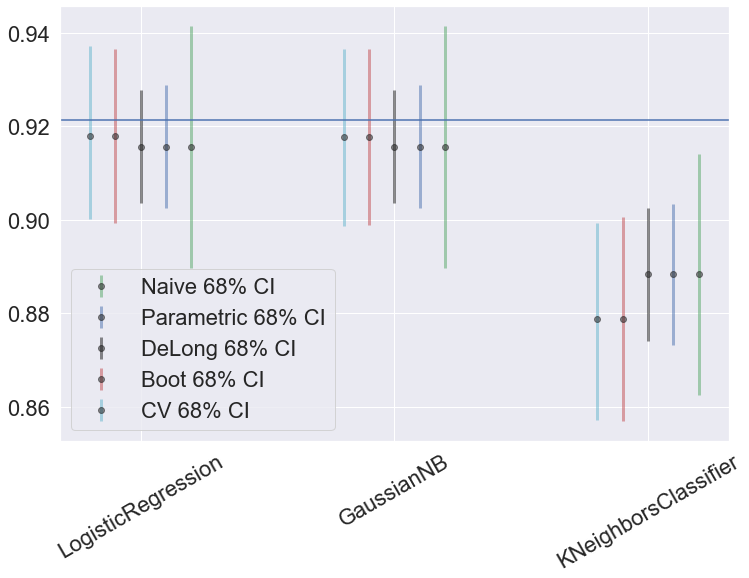

In [62]:
x = np.arange(len(aucs))
plt.figure(figsize=(12, 8))

plt.errorbar(x + 0.2, aucs, auc_var_naives, fmt='ok', lw=3, alpha=0.5, 
             ecolor='g', label='Naive 68% CI')
plt.errorbar(x + 0.1, aucs, auc_var_params, fmt='ok', lw=3, alpha=0.5, 
             ecolor='b', label='Parametric 68% CI')
plt.errorbar(x, aucs, auc_var_delongs, fmt='ok', lw=3, alpha=0.5, 
             ecolor='k', label='DeLong 68% CI')
plt.errorbar(x - 0.1, aucs_cv_means, auc_var_boots, fmt='ok', lw=3, alpha=0.5, 
             ecolor='r', label='Boot 68% CI')
plt.errorbar(x - 0.2, aucs_cv_means, np.array([aucs_cv_means - auc_ci_lows, auc_ci_highs - aucs_cv_means]), 
             fmt='ok', lw=3, alpha=0.5, ecolor='c', label='CV 68% CI')

plt.axhline(ideal_auc)

plt.xticks(x, model_names, rotation=30)
plt.legend()
plt.show()

## Посчитаем capture rate для `GaussianNB`

In [63]:
model = models["GaussianNB"]

In [76]:
from tqdm import trange

auc_var_naives = []
auc_var_params = []
auc_var_delongs = []
auc_var_boots = []
auc_ci_lows = []
auc_ci_highs = []
aucs_cv_means = []
aucs = []

for i in trange(100):
    X, y = make_classification(n_samples=1000)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    # estimate auc and variance
    auc = roc_auc_score(y_test, y_pred)
    n, m = y_test.sum(), len(y_test) - y_test.sum()
    auc_var_naive = roc_auc_variance_from_mann_whitney(n, m)
    auc_var_param = roc_auc_variance(auc, n, m)
    _, auc_var_delong = delong_roc_variance(y_test, y_pred)
    aucs_cv_mean, auc_var_boot, (auc_ci_low, auc_ci_high) = cv_auc_var_ci(
        model, X, y, B=50, first_type_error_rate=first_type_error_rate
    )

    auc_var_naives.append(auc_var_naive)
    auc_var_params.append(auc_var_param)
    auc_var_delongs.append(auc_var_delong)
    auc_var_boots.append(auc_var_boot)
    auc_ci_lows.append(auc_ci_low)
    auc_ci_highs.append(auc_ci_high)
    aucs_cv_means.append(aucs_cv_mean)
    aucs.append(auc)

100%|██████████| 100/100 [00:38<00:00,  2.57it/s]


In [85]:
1 - first_type_error_rate

0.68

In [78]:
auc_var_naives = np.sqrt(np.array(auc_var_naives))
auc_var_params = np.sqrt(np.array(auc_var_params))
auc_var_delongs = np.sqrt(np.array(auc_var_delongs))
auc_var_boots = np.array(auc_var_boots)
auc_ci_lows = np.array(auc_ci_lows)
auc_ci_highs = np.array(auc_ci_highs)
aucs_cv_means = np.array(aucs_cv_means)
aucs = np.array(aucs)

In [79]:
((aucs - auc_var_naives < ideal_auc) & (ideal_auc < aucs + auc_var_naives)).mean()

0.98

In [80]:
((aucs - auc_var_params < ideal_auc) & (ideal_auc < aucs + auc_var_params)).mean()

0.78

In [81]:
((aucs - auc_var_delongs < ideal_auc) & (ideal_auc < aucs + auc_var_delongs)).mean()

0.74

In [82]:
((aucs_cv_means - auc_var_boots < ideal_auc) & (ideal_auc < aucs_cv_means + auc_var_boots)).mean()

1.0

In [83]:
((auc_ci_lows < ideal_auc) & (ideal_auc < auc_ci_highs)).mean()

1.0

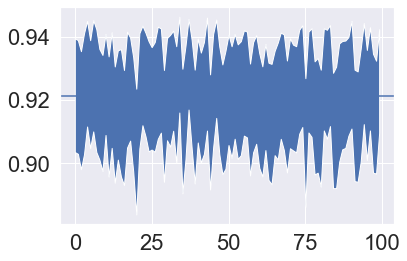

In [86]:
plt.fill_between(np.arange(len(auc_ci_lows)), auc_ci_lows, auc_ci_highs)
plt.axhline(ideal_auc)

Три проблемы:

  * Как мы увидели, классические способы оценки дисперсии AUC быстры, но дают симметричный интервал;
  * $r\times q-\mathrm{fold}$ CV даёт более красивые интервалы, но крайне дорогой по времени;
  * Для `LogisticRegression` видна некоторая смещённость оценок.

# 3. Simpson paradox

In [87]:
df = pd.read_csv("paradox.csv")
df = df.drop(df.columns[0], axis=1)
df.columns=["Neuroticism", "Salary", "Education"]

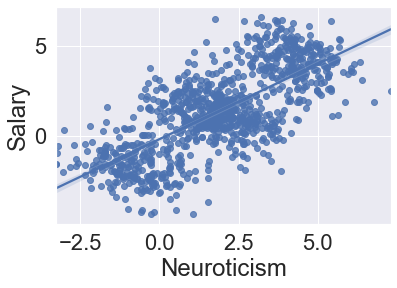

In [88]:
sns.regplot(data=df, x="Neuroticism", y="Salary");

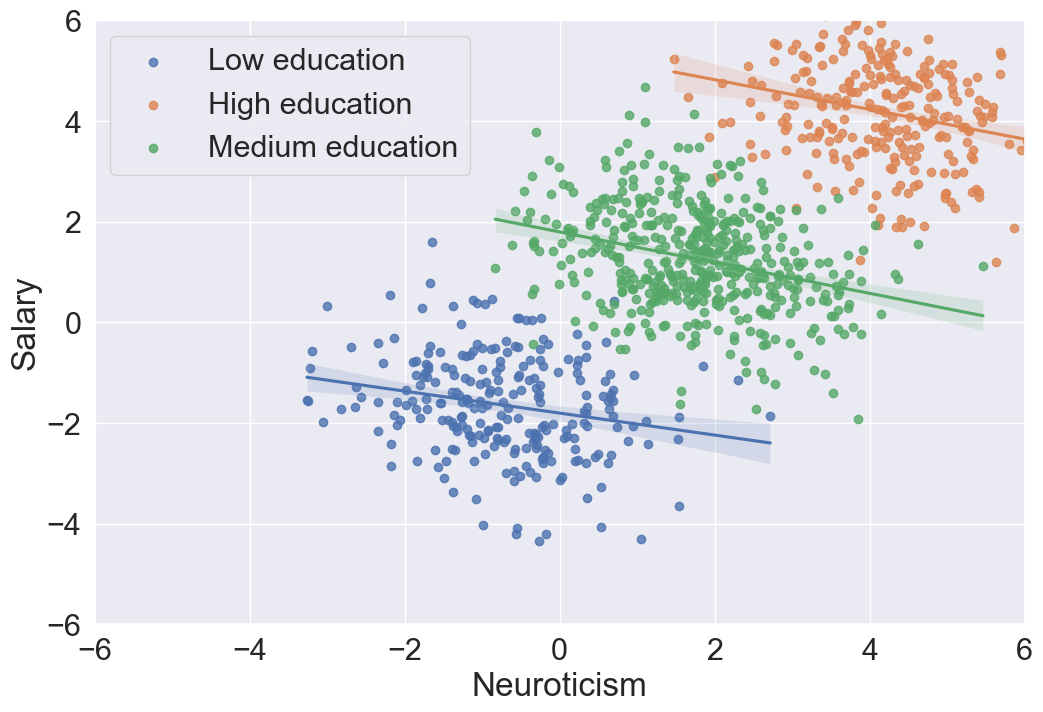

In [89]:
fig, ax = plt.subplots(figsize=(12, 8), dpi=100)

map_z = {
    1: "High education",
    0: "Low education", 
    2: "Medium education",
}

plt.xlim(-6,6);
plt.ylim(-6,6);

for z in df.Education.unique():
    sns.regplot(data=df[df.Education==z], x="Neuroticism", y="Salary", ax=ax, label=map_z[z])
    
plt.legend()
plt.show()